# First Example
In this example we will set up a basic pipeline to simulate the observation of an Earth twin (with a blackbody spectrum) around a Sun twin at 10 pc. We will assume an ideal instrument without any instrumental noise and simulate the spectrum that LIFE would measure under these circumstances.
To set up the pipeline we will use a config file, which can be downloaded (saved) [here](../_static/config_first_example.py).

### Import Necessary Modules

We start by importing the necessary modules.

In [1]:


import numpy as np
from matplotlib import pyplot as plt
from phringe.core.entities.scene import Scene
from phringe.core.entities.sources.exozodi import Exozodi
from phringe.core.entities.sources.local_zodi import LocalZodi
from phringe.core.entities.sources.planet import Planet
from phringe.core.entities.sources.star import Star

from lifesimmc.core.modules.generating.data_generation_module import DataGenerationModule
from lifesimmc.core.modules.generating.template_generation_module import TemplateGenerationModule
from lifesimmc.core.modules.loading.setup_module import SetupModule
from lifesimmc.core.modules.processing.correlation_map_module import CorrelationMapModule
from lifesimmc.core.modules.processing.ml_parameter_estimation_module import MLParameterEstimationModule
from lifesimmc.core.pipeline import Pipeline
from lifesimmc.lib.instrument import LIFEIdeal
from lifesimmc.lib.observation import LIFEObservation

### Define Instrument and Observation


In [17]:
# Use the predefined ideal LIFE baseline instrument, i.e. without any instrumental noise
inst = LIFEIdeal()

# User the predefined observation for the LIFE baseline design
obs = LIFEObservation(
    total_integration_time='10 d',
    detector_integration_time='0.1 d',
    optimized_star_separation='habitable-zone'
)

### Define Astrophysical Scene 

In [32]:
scene = Scene()

sun_twin = Star(
    name='Sun Twin',
    distance='10 pc',
    mass='1 Msun',
    radius='1 Rsun',
    temperature='5700 K',
    right_ascension='10 hourangle',
    declination='45 deg',
)

local_zodi = LocalZodi()

exozodi = Exozodi(level=3)

earth_twin = Planet(
    name='Earth Twin',
    has_orbital_motion=False,
    mass='1 Mearth',
    radius='1 Rearth',
    temperature='254 K',
    semi_major_axis='1 au',
    eccentricity='0',
    inclination='0 deg',
    raan='90 deg',
    argument_of_periapsis='0 deg',
    true_anomaly='45 deg',
    input_spectrum=None,
)

scene.add_source(sun_twin)
scene.add_source(local_zodi)
scene.add_source(exozodi)
scene.add_source(earth_twin)

### Set Up Pipeline

Then we set up the pipeline by creating a `Pipeline` object (see documentation [here](../source/core/pipeline.rst)). We also create and add the `SetupModule`, to which we pass the path to the config file in a `Configuration` object. It produces a `ConfigResource`, which we have given the name `conf` that contains information about the setup of the simulation and is used in other modules again.


In [33]:
# Create the pipeline
pipeline = Pipeline(gpu_index=2, seed=None, grid_size=40)

# Setup the simulation
module = SetupModule(n_setup_out='setup', instrument=inst, observation=obs, scene=scene)
pipeline.add_module(module)

We can pass the `Pipeline` a `gpu_index` corresponding to the index of the GPU we want to use. If no GPUs are available, this will simply be ignored, but it can also directly be set to `None`.
The `seed` argument accounts for the randomness in the simulation and can be set to a specific number to reproduce the same results over multiple runs. We set it to `None` here to produce random results. Finally, the `grid_size` corresponds to the spatial resolution of the simulations and is a trade-off between precision and computation power. `40` is a reasonable value, but higher values (e.g. `200`) can also be used for certain cases. 

### Generate Data

Next we add the `DataGenerationModule` to generate the raw data of the instrument. It requires the `ConfigResource` from the `SetupModule`above and outputs a `DataResource`, which contains the raw nulling data, and a `PlanetParamsResource`, which
contain the initial planetary parameters as specified in the config file.

In [34]:
module = DataGenerationModule(n_setup_in='setup', n_data_out='data', n_planet_params_out='params_init')
pipeline.add_module(module)

### Generate Templates and Correlation Map

To get a first idea of the quality of our measurement, we now generate a set of planetary templates in a $10^{-6}$ x $10^{-6}$ rad$^2$ patch of the sky and then correlate these templates with our data:

In [35]:
module = TemplateGenerationModule(n_setup_in='setup', n_template_out='temp', fov=1e-6)
pipeline.add_module(module)

module = CorrelationMapModule(n_data_in='data', n_template_in='temp', n_image_out='imag_corr')
pipeline.add_module(module)

We can run the pipeline with all the modules we have added so far and have a look at the generated correlation map:

Loading configuration...
Done
Generating synthetic data...


100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


Done
Generating templates...
Done
Calculating correlation map...
Done


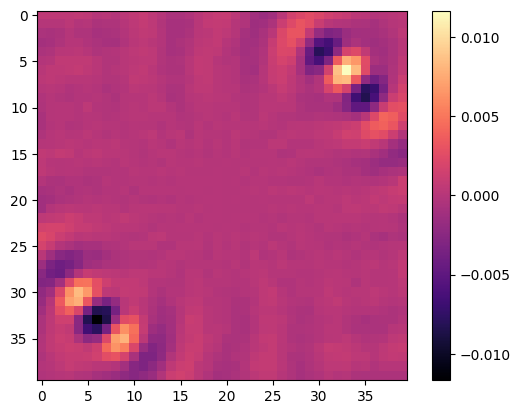

In [36]:
# Run pipeline
pipeline.run()

# Get the correlation map from the image resource and plot it
imag_corr = pipeline.get_resource('imag_corr').get_image(as_numpy=True)

plt.imshow(imag_corr, cmap='magma')
plt.colorbar()
plt.show()

### Extract the Planetary Spectrum

We now extract the planetary spectrum and coordinates from our data using a (numerical) maximum likelihood estimation. This will take a few seconds to run.

In [37]:
module = MLParameterEstimationModule(
    n_setup_in='setup',
    n_data_in='data',
    n_template_in='temp',
    n_planet_params_out='params_ml',
)
pipeline.add_module(module)
pipeline.run()

Performing numerical MLE...
Done


Finally, we plot the extracted flux and corresponding uncertainties:

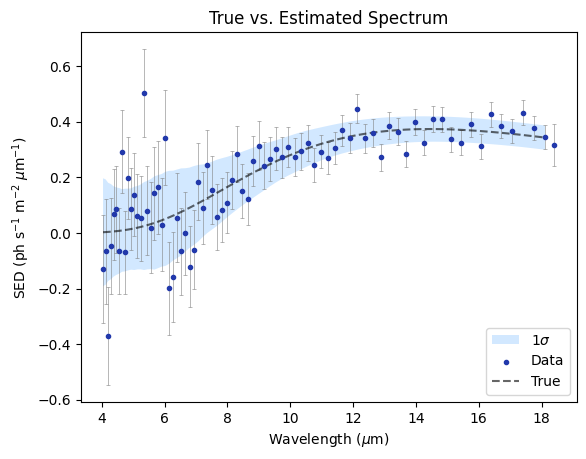

In [38]:
# Get the initial (input) parameters so we can plot the input spectrum (spectral energy distribution; SED) as a reference
params_init = pipeline.get_resource('params_init')
sed_init = params_init.params[0].sed.cpu().numpy()[:-1]  # Convert to numpy array from a torch Tensor
sed_init /= 1e6  # Convert to ph s-1 m-2 um-1
wavelengths = params_init.params[
    0].sed_wavelength_bin_centers.cpu().numpy()  # Convert to numpy array from a Torch tensor
wavelengths *= 1e6  # Convert from m to um

# Get the estimated parameters
params_ml = pipeline.get_resource('params_ml')
sed_estimated = params_ml.params[0].sed.cpu().numpy()
sed_estimated /= 1e6  # Convert to ph s-1 m-2 um-1
sed_err_low = params_ml.params[0].sed_err_low / 1e6
sed_err_high = params_ml.params[0].sed_err_high / 1e6

# Plot everything
yerr = np.stack([sed_err_low, sed_err_high])
plt.errorbar(wavelengths, sed_estimated, yerr=yerr, fmt='none', ecolor='gray', alpha=0.8, zorder=1,
             capsize=1.5,
             capthick=0.5, linewidth=0.5)
plt.fill_between(
    wavelengths[:-1],
    np.array(sed_init) - np.array(sed_err_low)[:-1],
    np.array(sed_init) + np.array(sed_err_high)[:-1],
    color='dodgerblue',
    edgecolor=None,
    lw=0,
    alpha=0.2,
    label='1$\sigma$',
    zorder=0
)
plt.scatter(wavelengths, sed_estimated, label='Data', color="xkcd:sapphire", zorder=2, marker='.')
plt.plot(wavelengths[:-1], sed_init, label='True', linestyle='dashed', color='black', alpha=0.6, zorder=1)
plt.title('True vs. Estimated Spectrum')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SED (ph s$^{-1}$ m$^{-2}$ $\mu$m$^{-1}$)')
plt.legend()
plt.show()